In [7]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

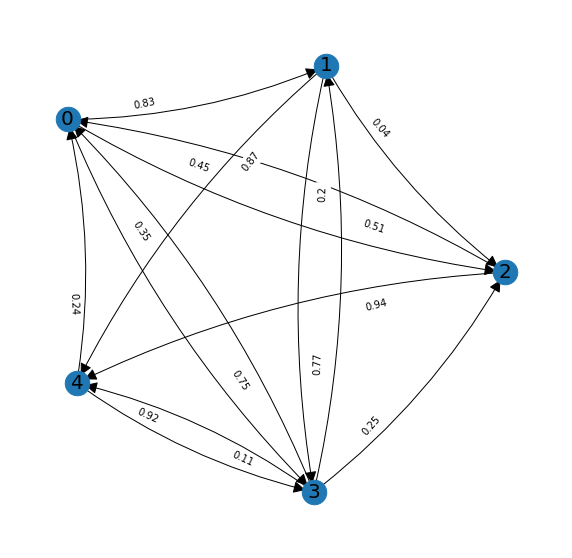

In [8]:
from Constants import *
import numpy as np
from Environment import Environment
from Network import Network
import random

def generate_click_probabilities(fully_connected : bool):

    adjacency_matrix = np.random.uniform(low=0.01, high = 1.000001, size = (NUM_OF_PRODUCTS, NUM_OF_PRODUCTS))
    adjacency_matrix[np.diag_indices(n = NUM_OF_PRODUCTS, ndim = 2)] = 0.0

    if not fully_connected:
        graph_mask = np.random.randint(low=0, high=2, size = adjacency_matrix.shape)
        adjacency_matrix = np.multiply(adjacency_matrix, graph_mask)
    
    # # maybe this normalization is not needed
    # for i in range(NUM_OF_PRODUCTS):
    #     col_sum = np.sum(adjacency_matrix[:, i])
    #     if col_sum != 0 :
    #         adjacency_matrix[:, i] = adjacency_matrix[:, i] / col_sum

    adjacency_matrix = np.round(adjacency_matrix, 2)
    return adjacency_matrix


def generate_observation_probabilities():
    obs_prob = np.zeros(shape = (NUM_OF_PRODUCTS, NUM_OF_PRODUCTS))
    for product in range(NUM_OF_PRODUCTS):
        available_products = [i for i in range(0,NUM_OF_PRODUCTS) if i != product]
        idxs = np.random.choice(a= available_products, size=2, replace=False)
        obs_prob[product][idxs[0]] = 1
        obs_prob[product][idxs[1]] = LAMBDA

    return obs_prob

def generate_prices (product_range : int, users_range : int):
    '''
    users_range is greater than product_range since we want to increase a little the probability 
    that a user will buy a given product
    '''
    return np.round(np.random.random(size = NUM_OF_PRODUCTS) * product_range , 2), np.round(np.random.random(size = NUM_OF_PRODUCTS) * users_range , 2)

if __name__ == '__main__' :

    # click_probabilities == edge weights in our case
    click_probabilities = generate_click_probabilities(fully_connected=False)
    observations_probabilities = generate_observation_probabilities()
    
    concentration_params = [100] + [70] * NUM_OF_PRODUCTS
    alpha_users = np.random.dirichlet( alpha= concentration_params, size = 1)


    product_prices, users_reservation_prices = generate_prices(product_range=70, users_range=100)

    env = Environment(alpha_users=alpha_users, 
                      users_reservation_prices = users_reservation_prices,
                      product_prices = product_prices,
                      click_probabilities = click_probabilities,
                      observations_probabilities = observations_probabilities)

    Network.print_graph(G=env.network.G)



In [10]:
env.generate_live_edge_graph(show_plots=False)

seed:3
primary product :3
the user reservation price is less than the product price
the user reservation price is less than the product price
the user reservation price is less than the product price
the user reservation price is less than the product price


[3]